In [1]:
import csv
import torch
import numpy as np
import pandas as pd

fields = ['input1', 'input2','output1', 'output2']
rows = []
h_target = torch.tensor([[1.,1.],[1.,-1]] / np.sqrt(2), dtype=torch.complex128)
x_target = torch.tensor([[0.,1.],[1.,0.]], dtype=torch.complex128)
z_target = torch.tensor([[1.,0.],[0.,-1.]], dtype=torch.complex128)

for i in range(8):
    phi = np.random.rand() * 2*np.pi
    theta = np.random.rand() * np.pi
    
    input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
    output = h_target @ input_qubit

    rows.append([np.sin(theta), np.cos(theta) * np.exp(1j * phi), output[0].item(), output[1].item()])

filename = 'qubit.csv'

with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

In [2]:
df = pd.read_csv('qubit.csv')
df

,input1,input2,output1,output2
0,0.474827,(0.38476741900497863-0.7915131619412096j),(0.6078252421634905-0.5596843242070352j),(0.06368193984735848+0.5596843242070352j)
1,0.388409,(0.40119195337626873-0.8295681435420967j),(0.5583323346470785-0.5865932597549518j),(-0.009038766932595088+0.5865932597549518j)
2,0.665070,(0.6913095309064529+0.2824412048650696j),(0.9591051606432568+0.19971609124658957j),(-0.018554153762431025-0.19971609124658957j)
3,0.988384,(-0.07928075784657485+0.1296570154985216j),(0.6428333135401408+0.0916813548874139j),(0.7549532365219841-0.0916813548874139j)
4,0.986524,(-0.13782214027122636-0.08817814766057389j),(0.6001228650737823-0.062351366163260494j),(0.7950328050406378+0.062351366163260494j)
5,0.751186,(0.5573526579942629-0.35366242710022183j),(0.9252767918132208-0.2500771004534599j),(0.13706110385304093+0.2500771004534599j)
6,0.737457,(-0.6475681575983349+0.19186778958112394j),(0.06356072511214311+0.13567101510408633j),(0.9793603961486661-0.13567101510408633j)
7,0.127826,(0.9828471417292867-0.13293646006793744j),(0.7853642538084334-0.09400027238097325j),(-0.6045915037647552+0.09400027238097325j)


In [1]:
#There are 3 versions to this code: 
# with a global phase
# without a global phase
# without a global phase and a different matrix for U

#This version has a global phase, but I'm not really sure how to get rid of it.

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd

num_qubits = 8

n_ghz = 4

batch_size = 1

num_epochs = 501

learning_rate = 1e-3

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.df = pd.read_csv('qubit.csv')
        self.df['input1'] = self.df['input1'].astype(complex)
        self.df['input2'] = self.df['input2'].astype(complex)
        self.df['output1'] = self.df['output1'].astype(complex)
        self.df['output2'] = self.df['output2'].astype(complex)

        dataset = []
        labels = []

        for i in range(num_qubits):
            dataset.append([self.df['input1'][i],self.df['input2'][i]])
            
        self.dataset = torch.tensor(dataset, dtype=torch.complex128)
        
        for i in range(num_qubits):
            labels.append([self.df['output1'][i],self.df['output2'][i]])
        
        self.labels = torch.tensor(labels, dtype=torch.complex128)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(torch.rand(1, dtype=torch.float64))
        self.α = Parameter(torch.rand(1, dtype=torch.float64))
        self.β = Parameter(torch.rand(1, dtype=torch.float64))
        self.ϕ = Parameter(torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        U = torch.exp(1j * ϕ / 2) * elements_to_matrix(
            [[torch.exp(1j * α) * torch.cos(θ), torch.exp(1j * β) * torch.sin(θ)],
             [- torch.exp(-1j * β) * torch.sin(θ), torch.exp(-1j * α) * torch.cos(θ)]])
        
        if len(x.shape) == 1:
            return U.matmul(x)
        else:
            return torch.einsum('ij,bj->bi', U, x)
    
model = HModel()

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)

def quantum_infidelity_batched(state_batch, target_state_batch, include_global_phase=False):

    if include_global_phase:
        return torch.stack([
            torch.abs((torch.angle(target_state - state))) * torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                    for state, target_state in zip(state_batch, target_state_batch)
        ]).mean()
    else:
        return torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
    
model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
q1 = torch.tensor([1,0],dtype=torch.complex128, requires_grad=False)
print(q0)

for n in range(n_ghz-1):
    q0 = torch.kron(q0,q1)
    q0 = q0 @ c_not
    c_not = torch.kron(i,c_not)
    print(q0)

epoch: 0, loss: 0.5377719933093592
epoch: 500, loss: 8.881784197001252e-16
tensor([-0.2954+0.6424j, -0.2954+0.6424j], dtype=torch.complex128,
       grad_fn=<MvBackward0>)
tensor([-0.2954+0.6424j,  0.0000+0.0000j,  0.0000+0.0000j, -0.2954+0.6424j],
       dtype=torch.complex128, grad_fn=<SqueezeBackward4>)
tensor([-0.2954+0.6424j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j, -0.2954+0.6424j],
       dtype=torch.complex128, grad_fn=<SqueezeBackward4>)
tensor([-0.2954+0.6424j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j, -0.2954+0.6424j],
       dtype=torch.complex128, grad_fn=<SqueezeBackward4>)


epoch: 0, loss: 0.3432470590721669
epoch: 500, loss: 0.06547452034808056
epoch: 1000, loss: 0.0037096270396033
epoch: 1500, loss: 4.607493956802766e-05
epoch: 2000, loss: 8.789398833752848e-08
epoch: 2500, loss: 1.652170067423242e-11
epoch: 3000, loss: 4.163336342344337e-16
tensor([0.7071-1.6182e-17j, 0.7071-1.5323e-08j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)
tensor([0.7071-1.6182e-17j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.7071-1.5323e-08j], dtype=torch.complex128,
       grad_fn=<SqueezeBackward4>)


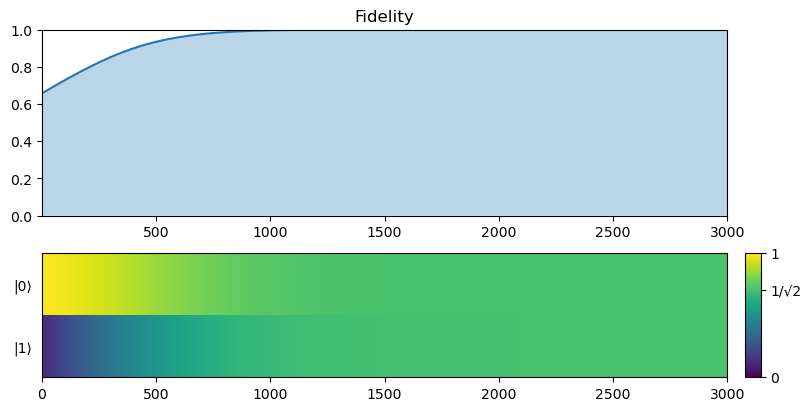

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

num_qubits = 8

n_ghz = 4

batch_size = 8

num_epochs = 3001

learning_rate = 1e-3

loss_graph = []

q1_graph = []
q2_graph = []


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)

#===============================================================================================================================
#Create the data set

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.df = pd.read_csv('qubit.csv')
        self.df['input1'] = self.df['input1'].astype(complex)
        self.df['input2'] = self.df['input2'].astype(complex)
        self.df['output1'] = self.df['output1'].astype(complex)
        self.df['output2'] = self.df['output2'].astype(complex)

        dataset = []
        labels = []

        for i in range(num_qubits):
            dataset.append([self.df['input1'][i],self.df['input2'][i]])
            
        self.dataset = torch.tensor(dataset, dtype=torch.complex128)
        
        for i in range(num_qubits):
            labels.append([self.df['output1'][i],self.df['output2'][i]])
        
        self.labels = torch.tensor(labels, dtype=torch.complex128)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]
    
#===============================================================================================================================
#Load the data set

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================
#The model

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ

        U = elements_to_matrix(
            [[torch.exp(1j * α) * torch.cos(θ), torch.exp(1j * β) * torch.sin(θ)],
             [- torch.exp(-1j * β) * torch.sin(θ), torch.exp(-1j * α) * torch.cos(θ)]])
        
        if len(x.shape) == 1:
            return U.matmul(x)
        else:
            q_test = torch.tensor([1,0], dtype=torch.complex128, requires_grad=False)
            out = U @ q_test
            q1_graph.append(abs(out[0].tolist()))
            q2_graph.append(abs(out[1].tolist()))
            
            return torch.einsum('ij,bj->bi', U, x)        

#===============================================================================================================================
#Loss function

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================
#Train the model

model = HModel()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
#===============================================================================================================================
#Test the model

model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
q1 = torch.tensor([1,0],dtype=torch.complex128, requires_grad=False)

fake_global_phase = torch.angle(q0[0])
q0 = torch.exp(-1j * fake_global_phase) * q0
print(q0)

for n in range(n_ghz-1):
    q0 = torch.kron(q0,q1)
    q0 = q0 @ c_not
    c_not = torch.kron(i,c_not)
print(q0)

#===============================================================================================================================
#Graph the progress of the model

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1.5,1), layout='constrained')

x_graph = np.arange(num_epochs * num_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * num_qubits / batch_size))

q12_graph = np.array([q2_graph,q1_graph])

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = ax2.pcolormesh(q12_graph, norm=norm, cmap='viridis')

cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=8)
cbar.set_ticks([0, 1/np.sqrt(2), 1])
cbar.set_ticklabels(["0", "1/√2", "1"])

ax2.set_yticks([0.5,1.5], labels=['|1⟩','|0⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * num_qubits / batch_size-1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

#===============================================================================================================================
#Suppress console output

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [90]:
#This version uses a different matrix for U
#It doesn't have any problems with being negative or having some rotation, but it isn't as accurate
#It usually only gets so precise and takes considerably more epochs
#It's not great, but it's good enough

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd

num_qubits = 8

n_ghz = 4

batch_size = 1

num_epochs = 1001

learning_rate = 1e-3

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.df = pd.read_csv('qubit.csv')
        self.df['input1'] = self.df['input1'].astype(complex)
        self.df['input2'] = self.df['input2'].astype(complex)
        self.df['output1'] = self.df['output1'].astype(complex)
        self.df['output2'] = self.df['output2'].astype(complex)

        dataset = []
        labels = []

        for i in range(num_qubits):
            dataset.append([self.df['input1'][i],self.df['input2'][i]])
            
        self.dataset = torch.tensor(dataset, dtype=torch.complex128)
        
        for i in range(num_qubits):
            labels.append([self.df['output1'][i],self.df['output2'][i]])
        
        self.labels = torch.tensor(labels, dtype=torch.complex128)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(torch.rand(1, dtype=torch.float64))
        self.α = Parameter(torch.rand(1, dtype=torch.complex128))
        self.β = Parameter(torch.rand(1, dtype=torch.complex128))
        self.ϕ = Parameter(torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
     
        U = elements_to_matrix([[α,β],
                                [-torch.exp(1j * ϕ) * β.conj(),torch.exp(1j * ϕ) * α.conj()]])

        if len(x.shape) == 1:
            return U.matmul(x)
        else:
            return torch.einsum('ij,bj->bi', U, x)
    
model = HModel()

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)

def quantum_infidelity_batched(state_batch, target_state_batch):

    return torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
    
model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
q1 = torch.tensor([1,0],dtype=torch.complex128, requires_grad=False)
print(q0)

for n in range(n_ghz-1):
    q0 = torch.kron(q0,q1)
    q0 = q0 @ c_not
    c_not = torch.kron(i,c_not)
    print(q0)
    fake_global_phase = torch.angle(q0[0])
    print(torch.exp(-1j * fake_global_phase) * q0)

epoch: 0, loss: 0.6075675094501105
epoch: 500, loss: 0.052130496817883745
epoch: 1000, loss: 0.02320172913401737
epoch: 1500, loss: 0.01581278237248107
epoch: 2000, loss: 0.010459663382475323
epoch: 2500, loss: 0.006592592955255147
epoch: 3000, loss: 0.004200843956813388
tensor([ 0.2584+0.6050j, -0.0294+0.7776j], dtype=torch.complex128,
       grad_fn=<MvBackward0>)
tensor([ 0.2584+0.6050j,  0.0000+0.0000j,  0.0000+0.0000j, -0.0294+0.7776j],
       dtype=torch.complex128, grad_fn=<SqueezeBackward4>)
tensor([0.6579-2.7756e-17j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.7036+3.3251e-01j], dtype=torch.complex128, grad_fn=<MulBackward0>)
tensor([ 0.2584+0.6050j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j, -0.0294+0.7776j],
       dtype=torch.complex128, grad_fn=<SqueezeBackward4>)
tensor([0.6579-2.7756e-17j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
  

In [10]:
def QFT(qubits, num_ancillae = 0):
    '''Applies quantum Fourier transform to inputs, then shuffles the output to be in the same order as input'''
    N = len(qubits) - num_ancillae
    for n in range(N):
        target = qubits[n]
        squanch.H(target)
        for m in range(1, N - n):
            squanch.CPHASE(qubits[n + m], target, 2 * np.pi / (2 ** (m + 1)))
    # At this point, the output bits are in reverse order, so swap first with last and so on to get right order
    for n in range(N // 2):
        squanch.SWAP(qubits[n], qubits[N - n - 1])

epoch: 0, loss: 0.309939691679161
epoch: 500, loss: 0.09764366414853334
epoch: 1000, loss: 0.0042036896514889704
epoch: 1500, loss: 4.4020636376956856e-05
epoch: 2000, loss: 8.441038032436232e-08
epoch: 2500, loss: 1.6513235223669653e-11
epoch: 3000, loss: 3.3306690738754696e-16
tensor([-1.4107e-08-0.7071j, -4.3134e-09-0.7071j], dtype=torch.complex128,
       grad_fn=<MvBackward0>)
tensor([-1.4107e-08-0.7071j,  0.0000e+00+0.0000j,  0.0000e+00+0.0000j,
        -4.3134e-09-0.7071j], dtype=torch.complex128,
       grad_fn=<SqueezeBackward4>)
tensor([-1.4107e-08-0.7071j,  0.0000e+00+0.0000j,  0.0000e+00+0.0000j,
         0.0000e+00+0.0000j,  0.0000e+00+0.0000j,  0.0000e+00+0.0000j,
         0.0000e+00+0.0000j, -4.3134e-09-0.7071j], dtype=torch.complex128,
       grad_fn=<SqueezeBackward4>)
tensor([-1.4107e-08-0.7071j,  0.0000e+00+0.0000j,  0.0000e+00+0.0000j,
         0.0000e+00+0.0000j,  0.0000e+00+0.0000j,  0.0000e+00+0.0000j,
         0.0000e+00+0.0000j,  0.0000e+00+0.0000j,  0.0000e+00

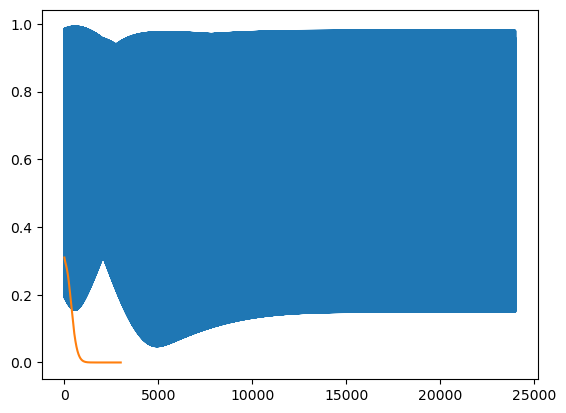

In [6]:
#This version has no global phase.
#One problem I encountered is that whenever I run it, the output is always [0+1j, 0+1j] / sqrt(2)
#I found a way to fix it, which I explain below

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt

num_qubits = 8

n_ghz = 4

batch_size = 8

num_epochs = 3001

learning_rate = 1e-3

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.df = pd.read_csv('qubit.csv')
        self.df['input1'] = self.df['input1'].astype(complex)
        self.df['input2'] = self.df['input2'].astype(complex)
        self.df['output1'] = self.df['output1'].astype(complex)
        self.df['output2'] = self.df['output2'].astype(complex)

        dataset = []
        labels = []

        for i in range(num_qubits):
            dataset.append([self.df['input1'][i],self.df['input2'][i]])
            
        self.dataset = torch.tensor(dataset, dtype=torch.complex128)
        
        for i in range(num_qubits):
            labels.append([self.df['output1'][i],self.df['output2'][i]])
        
        self.labels = torch.tensor(labels, dtype=torch.complex128)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        y = torch.tensor([[0,-1j],[1j,0]], dtype=torch.complex128) 
        
        U = elements_to_matrix(
            [[torch.exp(1j * α) * torch.cos(θ), torch.exp(1j * β) * torch.sin(θ)],
             [- torch.exp(-1j * β) * torch.sin(θ), torch.exp(-1j * α) * torch.cos(θ)]])
        
#         U = U @ y
        #For whatever reason, if I don't multiply by y, 
        #the output is always [0+1j, 0+1j] / sqrt(2) instead of [1+0j, 1+0j] / sqrt2
        #However, even after multiplying by y, the output is occasionally negative
        
        if len(x.shape) == 1:
            return U.matmul(x)
        else:
            return torch.einsum('ij,bj->bi', U, x)
    
model = HModel()

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)

loss_graph = []
loss2_graph = []

q1_graph = []
q2_graph = []

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    loss2_graph.append(loss.item())
    
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        for a in range(batch_size):
            
            q1_graph.append(abs(outputs[a,0].tolist()))
            q2_graph.append(abs(outputs[a,1].tolist()))
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        

model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
q1 = torch.tensor([1,0],dtype=torch.complex128, requires_grad=False)
print(q0)

for n in range(n_ghz-1):
    q0 = torch.kron(q0,q1)
    q0 = q0 @ c_not
    c_not = torch.kron(i,c_not)
    print(q0)
#     fake_global_phase = torch.angle(q0[0])
#     print(torch.exp(-1j * fake_global_phase) * q0)

x_qubit_graph = np.arange(num_epochs * batch_size)
x_loss_graph = np.arange(num_epochs * num_qubits / batch_size)

plt.plot(x_qubit_graph,q1_graph)
plt.plot(x_loss_graph,loss2_graph)